In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

import numpy as np
import pandas as pd
import glob
from sklearn.metrics import r2_score
from IPython.display import display, HTML
from datetime import datetime

import h5py
import os

import matplotlib as mpl

# 1. process hdf vector

In [2]:
#read .h5 files
output = []
lake_num   = 164
lake_ids   = range(1,165) 
key_word = 'VNP' #VNP or VJ1
files = glob.glob('./VNP28C2/VNP28C2*.h5', recursive=True) #look for input files

for fname in files:
    #print(fname)
    mdate = fname.split('/')[-1].split('.')[1]
    
    with h5py.File(fname, 'r') as hf:
        mdata=hf['lakes']             
        for i in range(lake_num):
            output.append([mdate, lake_ids[i], mdata[i][3]])#lake area
            
output_df = pd.DataFrame(output, columns=['date', 'lake_id', 'pge698_area'])
display(output_df)


date  lake_id  pge698_area
0      A2012017        1 -9999.000000
1      A2012017        2  4928.563139
2      A2012017        3  4272.566233
3      A2012017        4  4907.311930
4      A2012017        5 -9999.000000
...         ...      ...          ...
74943  A2021361      160 -9999.000000
74944  A2021361      161    25.973699
74945  A2021361      162    43.790369
74946  A2021361      163    31.769484
74947  A2021361      164    28.978921

[74948 rows x 3 columns]

In [3]:
date_start = datetime.strptime('1/1/2012', "%m/%d/%Y")  ## any date before the start of VIIRS is good

def sum_area(group):
    
    if np.min(group['pge698_area'] == 0):
        c = 0
    else:
        c = np.sum(group['pge698_area'])
        
    return c

df = output_df.groupby(['date', 'lake_id']).apply(lambda grp: sum_area(grp)).reset_index()
df = df.rename({0: 'pge698_area'}, axis=1).replace({0: np.nan})
df['date'] = pd.to_datetime(df['date'], format='A%Y%j', errors='coerce')
df['date_int'] = df['date'].apply(lambda x: (x-date_start).days)
df = df.sort_values(['lake_id', 'date'])
display(df)
df.to_csv(key_word+'28C2.csv')

date  lake_id  pge698_area  date_int
0     2012-01-17        1 -9999.000000        16
164   2012-01-25        1 -9999.000000        24
328   2012-02-02        1 -9999.000000        32
492   2012-02-10        1 -9999.000000        40
656   2012-02-18        1 -9999.000000        48
...          ...      ...          ...       ...
74291 2021-11-25      164    29.837556      3616
74455 2021-12-03      164 -9999.000000      3624
74619 2021-12-11      164    30.052214      3632
74783 2021-12-19      164    30.266873      3640
74947 2021-12-27      164    28.978921      3648

[74948 rows x 4 columns]

# 2. remove outliers and interpolate

In [4]:
def remove_bias(values, dates, wz):
    
    ## values: area or storage time series
    ## dates: corresponding dates (in integer)
    ## wz: windows size for calculating the moving average to determine the outliers
    
    weight = np.arange(1,wz,1)[int(wz/2):]
    weight = np.concatenate((weight, np.ones(len(values)-wz+1)*wz, np.flip(weight, 0)))/wz
    
    nol = 2
    limit = 50
    while nol > 0 and limit > 0:
        wt_ma = np.convolve(values, np.ones((wz,))/wz, mode='same')
        
        bias = values - wt_ma/weight
        b_avg = np.average(bias)
        b_sd = np.std(bias)
        
        outlier = [0 if (x >= b_avg+3*b_sd or x <= b_avg-3*b_sd) else 1 for x in bias]
        inreduce = nol - (len(outlier) - np.sum(outlier))
        nol = len(outlier) - np.sum(outlier)
        limit = limit - 1
        #print(nol)
        
        n_dates = [x for x,y in zip(dates, outlier) if y==1]
        n_enh = [x for x,y in zip(values, outlier) if y==1]
        if len(n_dates) >= 5:
            values = np.interp(dates, n_dates, n_enh)
        else:
            return dates, values
        
        if inreduce == 0 and nol <=2:
            break
    return n_dates, n_enh

In [5]:
lake_info_data = pd.read_table('./viirs_lake_info.txt', sep=' ')

In [6]:
wz = 7 # moving window

output_intp = []
for lake_id, group in df.groupby('lake_id'):
    
    lake_info = lake_info_data[lake_info_data['LAKE_ID'] == lake_id].iloc[0]
    sto_cap_km3, area_cap_km2, elev_cap_m, a, b = lake_info[['sto_cap_km3','area_cap_km2', 'elev_cap_m', 'a', 'b']]
        
    group_valid = group[(group['pge698_area'] > 0)] 
    
    if len(group_valid) > wz:
        areas = group_valid['pge698_area'].values
        dates = group_valid['date_int'].values
        dates_new, areas_new = remove_bias(areas, dates, wz)
        
        areas_intp = np.interp(group['date_int'], dates_new, areas_new)
    else:
        areas_new = group[(group['pge698_area'] > 0)]['pge698_area'].values
        dates_new = group[(group['pge698_area'] > 0)]['date_int'].values
        areas_intp = np.interp(group['date_int'], dates_new, areas_new)
        
    elevs_intp = [a*area+b for area in areas_intp]
    stors_intp = [sto_cap_km3 - (area_cap_km2+area)*(elev_cap_m-elev)/2000. 
                  for area, elev in zip(areas_intp, elevs_intp)]
    
    intp_flag = [0 if area==area_new else 1 for area, area_new in zip(group['pge698_area'], areas_intp)]

    group_new = pd.DataFrame({'date': group['date'], 'lake_area': areas_intp, 'lake_elevation': elevs_intp, 
                        'lake_storage': stors_intp, 'intp_flag': intp_flag})
    group_new['lake_id'] = lake_id
    output_intp.append(group_new)
    
df_intp = pd.concat(output_intp, axis=0).reset_index(drop=True)
display(df_intp)
df_intp.to_csv(key_word+'28C2_outlier_removed.csv', index=False)

date     lake_area  lake_elevation  lake_storage  intp_flag  \
0     2012-01-17  31084.078504      451.601764  23448.239392          1   
1     2012-01-25  31084.078504      451.601764  23448.239392          1   
2     2012-02-02  31084.078504      451.601764  23448.239392          1   
3     2012-02-10  31084.078504      451.601764  23448.239392          1   
4     2012-02-18  31084.078504      451.601764  23448.239392          1   
...          ...           ...             ...           ...        ...   
74943 2021-11-25     29.837556      168.308495      0.485293          0   
74944 2021-12-03     29.944885      168.346923      0.486442          1   
74945 2021-12-11     30.052214      168.385351      0.487594          0   
74946 2021-12-19     30.266873      168.462207      0.489912          0   
74947 2021-12-27     28.978921      168.001071      0.476252          0   

       lake_id  
0            1  
1            1  
2            1  
3            1  
4            1  
...        ...  
74943      164  
74944      164  
74945      164  
74946      164  
74947      164  

[74948 rows x 6 columns]

# 3. check lakes

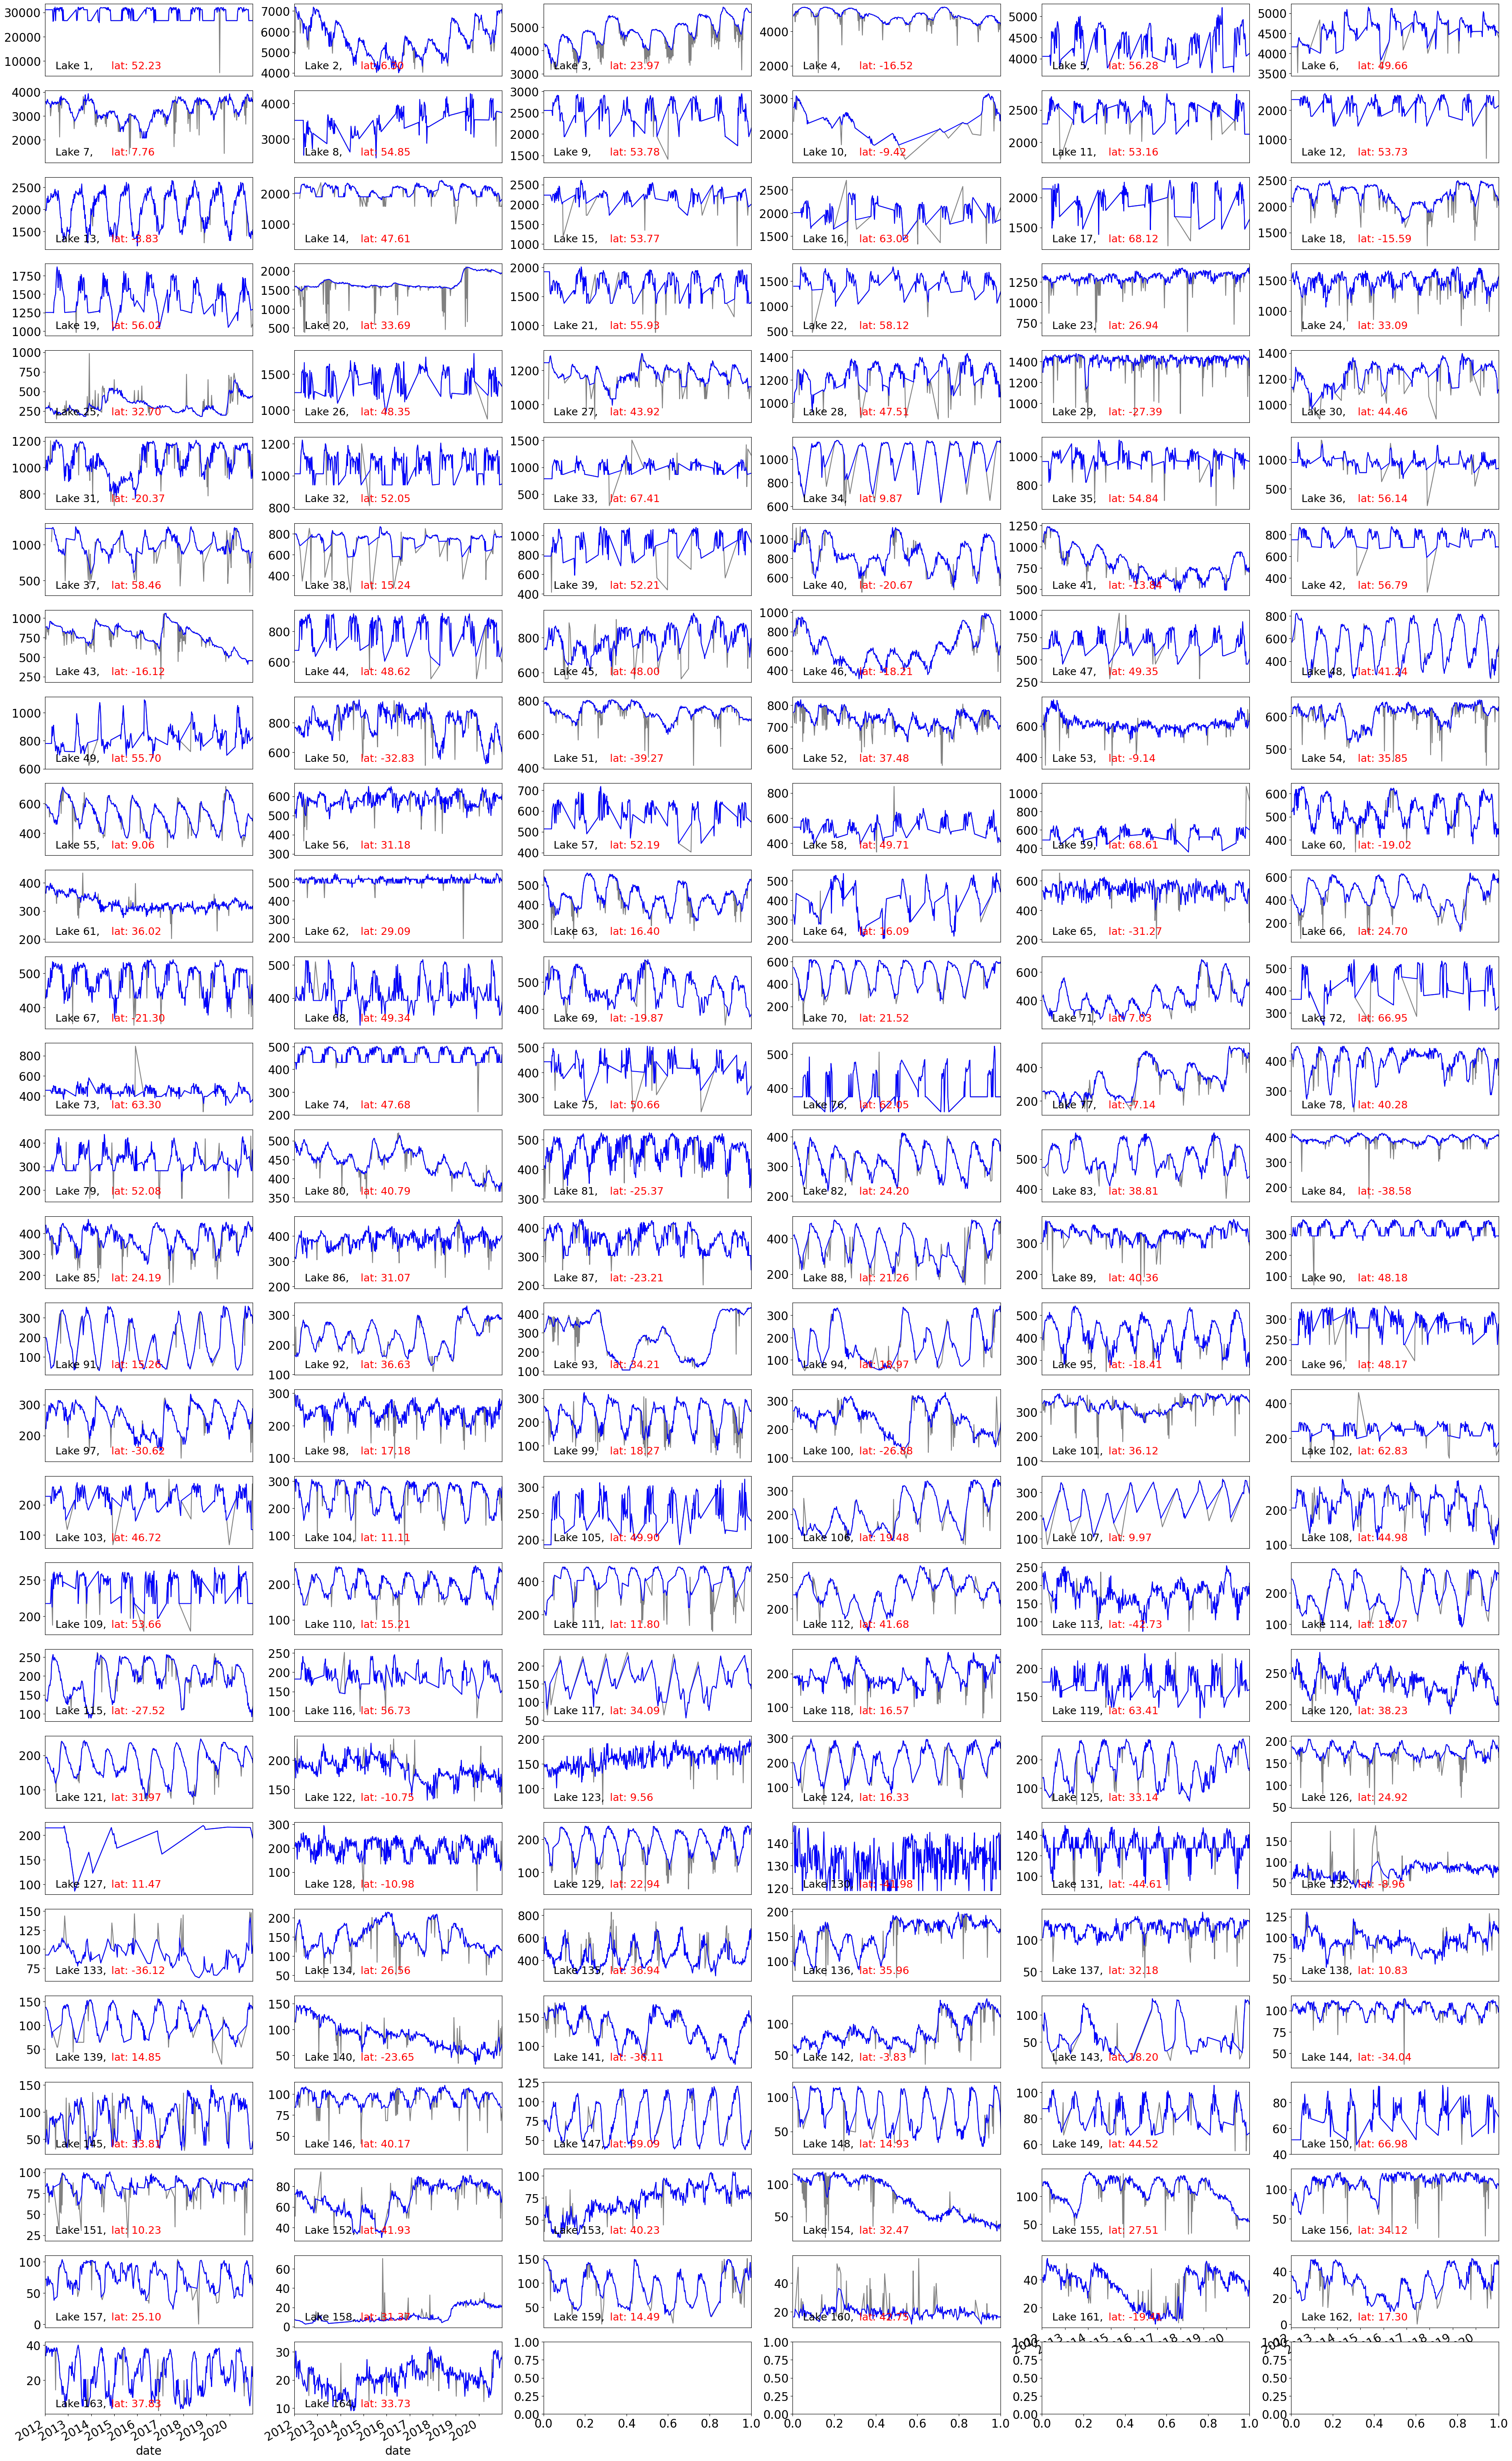

In [7]:
fig, axs = plt.subplots(28, 6, figsize=(45, 85))
axs = axs.ravel()
plt.rcParams.update({'font.size': 15})

left = datetime(2012, 1, 1)
right = datetime(2020, 12, 31)

for lake_id in sorted(df['lake_id'].astype(int).unique()):
    
    orig_data = df[df['lake_id'] == lake_id]
    lat = lake_info_data[lake_info_data['LAKE_ID'] == lake_id].iloc[0]['LAT_DD']
    orig_data = orig_data[orig_data['pge698_area'] > 0]
    orig_data.plot(ax=axs[lake_id-1], x='date', y='pge698_area', color='grey', legend=False)
    
    new_data = df_intp[df_intp['lake_id'] == lake_id]
    new_data.plot(ax=axs[lake_id-1], x='date', y='lake_area', color='blue', legend=False)
    
    axs[lake_id-1].text(0.05, 0.10, 'Lake {:d}, '.format(lake_id), fontsize=18, color='k', transform=axs[lake_id-1].transAxes)
    axs[lake_id-1].text(0.32, 0.10, 'lat: {:.2f}'.format(lat), fontsize=18, color='r', transform=axs[lake_id-1].transAxes)
    axs[lake_id-1].set_xlim(left, right)
    if lake_id<=160:
        axs[lake_id-1].axes.get_xaxis().set_visible(False)

fig.savefig(key_word+'28C2_outlier_removal.png', bbox_inches='tight')

# 4. save outlier removed data

In [9]:
for i in range(1,165):
    df_out = df_intp[df_intp['lake_id'] == i] 
    df_out['date'] = df_out['date'].dt.strftime('%Y%j')
    df_out.to_csv('./lakewise_extracted_outlier_removed/C2/' + str(i) +'.csv', index=False)
    

C:\Users\shahd\AppData\Local\Temp\ipykernel_13268\251217071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out['date'] = df_out['date'].dt.strftime('%Y%j')
